## Set up environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
plt.style.use('ggplot')
# Prepare data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
# Data pre-processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
# Model architectures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
# Hyperparameters tuning
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold

# Train and metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve, 
    auc, 
    f1_score, 
    average_precision_score, 
    make_scorer
)

In [2]:
# Import cleaned df
tc10 = pd.read_csv('./CSV/tc10.csv', header=0)
tc10_data = tc10.iloc[:, :7]
tc10_labels = tc10.iloc[:, -1]

mirowski = pd.read_csv('./CSV/mirowski.csv', header=0)
mirowski_data = mirowski.iloc[:, :7]
mirowski_labels = mirowski.iloc[:, -1]

hk = pd.read_csv('./CSV/hk.csv', header=0)
hk_data = hk.iloc[:, :7]
hk_labels = hk.iloc[:, -1]

smote = SMOTE(sampling_strategy='minority')
smote_data, smote_labels = smote.fit_resample(tc10_data, tc10_labels)

c:\Users\chanttsh\AppData\Local\miniconda3\envs\env1\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\chanttsh\AppData\Local\miniconda3\envs\env1\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [3]:
models = {
    "knn": KNeighborsClassifier(),
    "random_forest": RandomForestClassifier(random_state=41),
    "svc_linear": SVC(kernel='linear', probability=True, random_state=41),
    "svc_quad": SVC(kernel='poly', probability=True, random_state=41),
    "svc_rbf": SVC(kernel='rbf', probability=True, random_state=41),
    "neural_network": MLPClassifier(hidden_layer_sizes=(10,), activation='tanh', solver='sgd', max_iter=10000, random_state=41)
}

## TC 10 dataset visualised

A preliminary plots to see how the data look like

In [4]:
# Helper function for 3D plots
def DGA_plot3d(X, y, axis_labels, fig, subplot_num, ax_title=''):
    (nrows, ncols, index) = subplot_num
    ax = fig.add_subplot(nrows, ncols, index, projection='3d')
    ax.scatter(X[X.columns[0]][y == 1], 
               X[X.columns[1]][y == 1], 
               X[X.columns[2]][y == 1], 
               c='r', label='positive')
    ax.scatter(X[X.columns[0]][y == 0], 
               X[X.columns[1]][y == 0], 
               X[X.columns[2]][y == 0], 
               c='g', label='negative')
    ax.set_xlabel(f'${axis_labels[0]}$')
    ax.set_ylabel(f'${axis_labels[1]}$')
    ax.set_zlabel(f'${axis_labels[2]}$')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-2, 2)
    ax.set_title(f'{ax_title} ${axis_labels[0]}$, ${axis_labels[1]}$, ${axis_labels[2]}$')
    return ax

pipeline = Pipeline([
    ('yj_transform', PowerTransformer()),  # Yeo-Johnson transformation
])

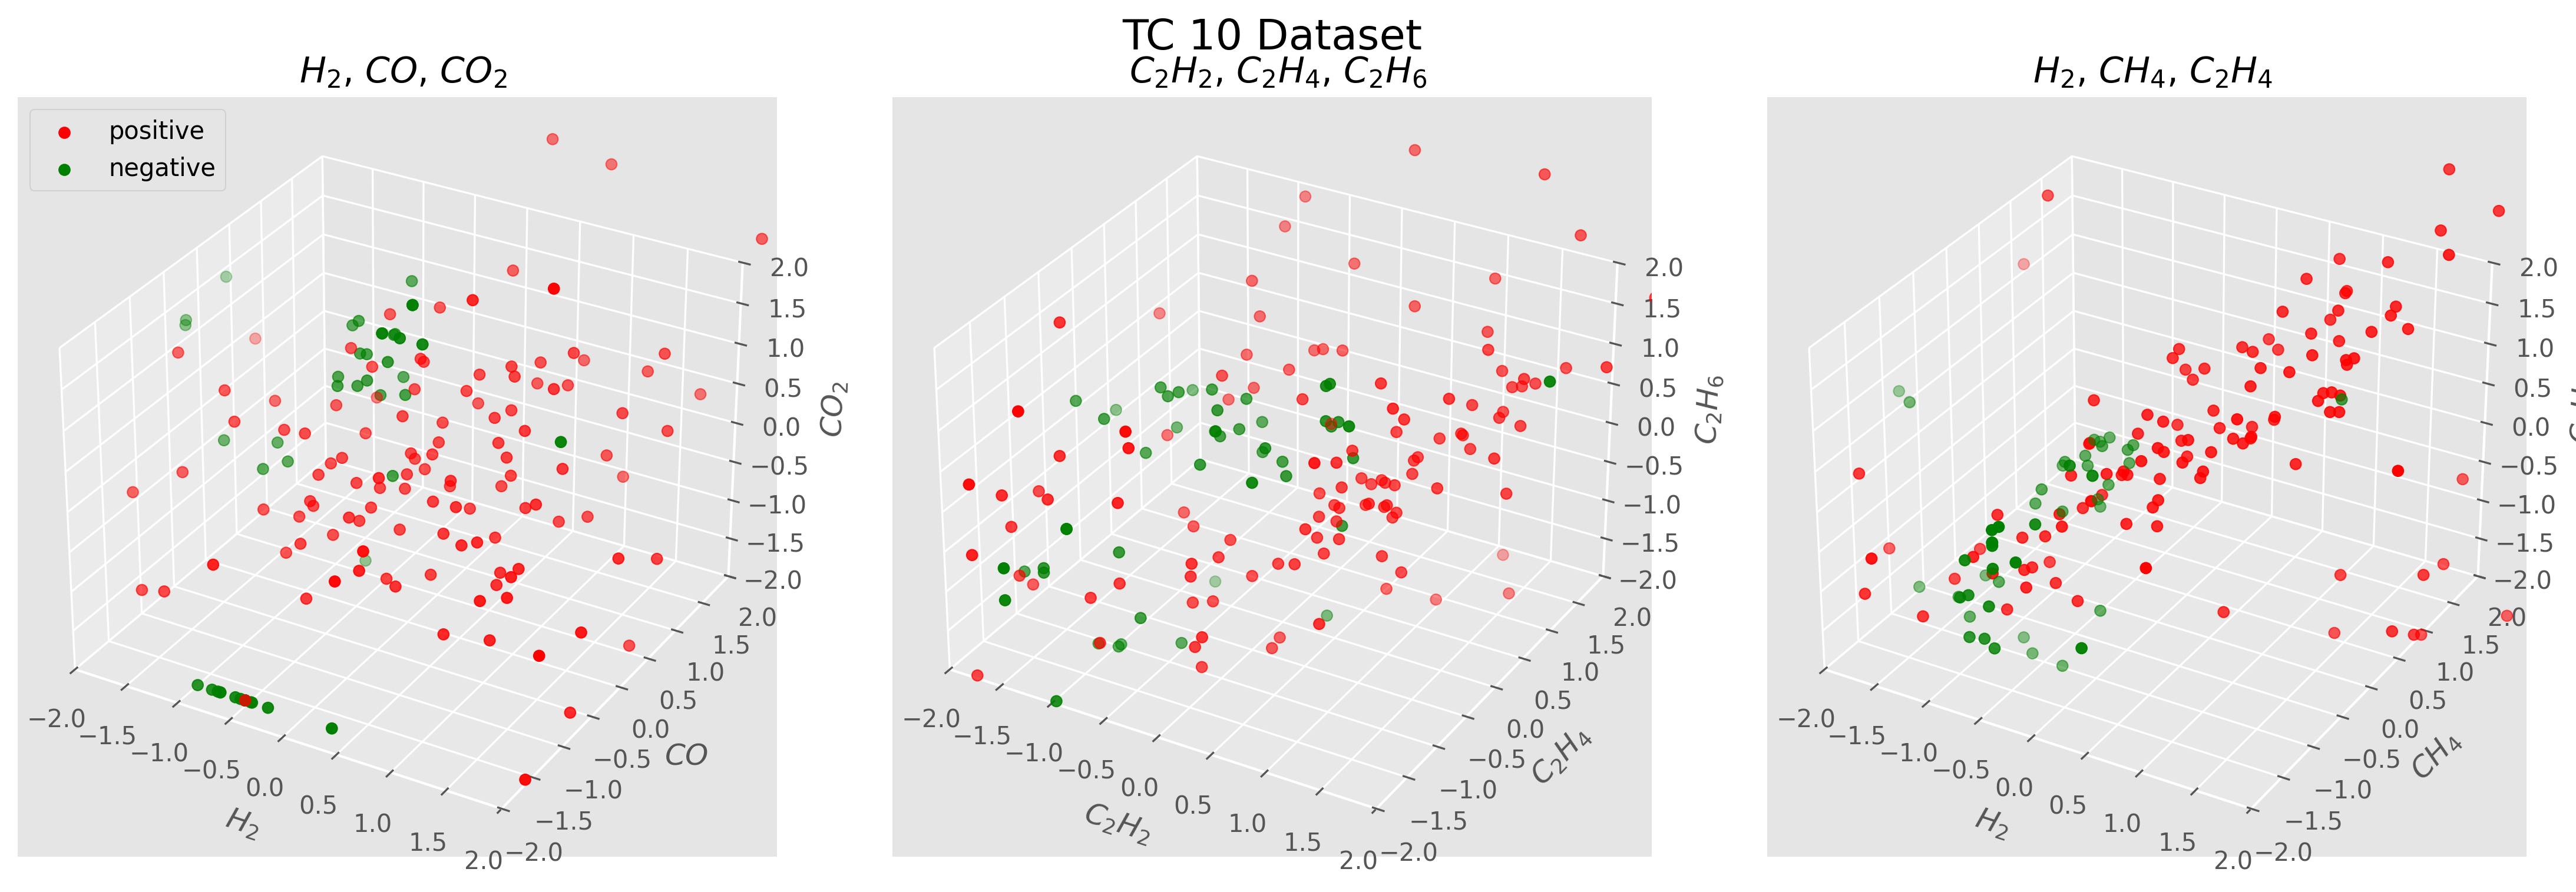

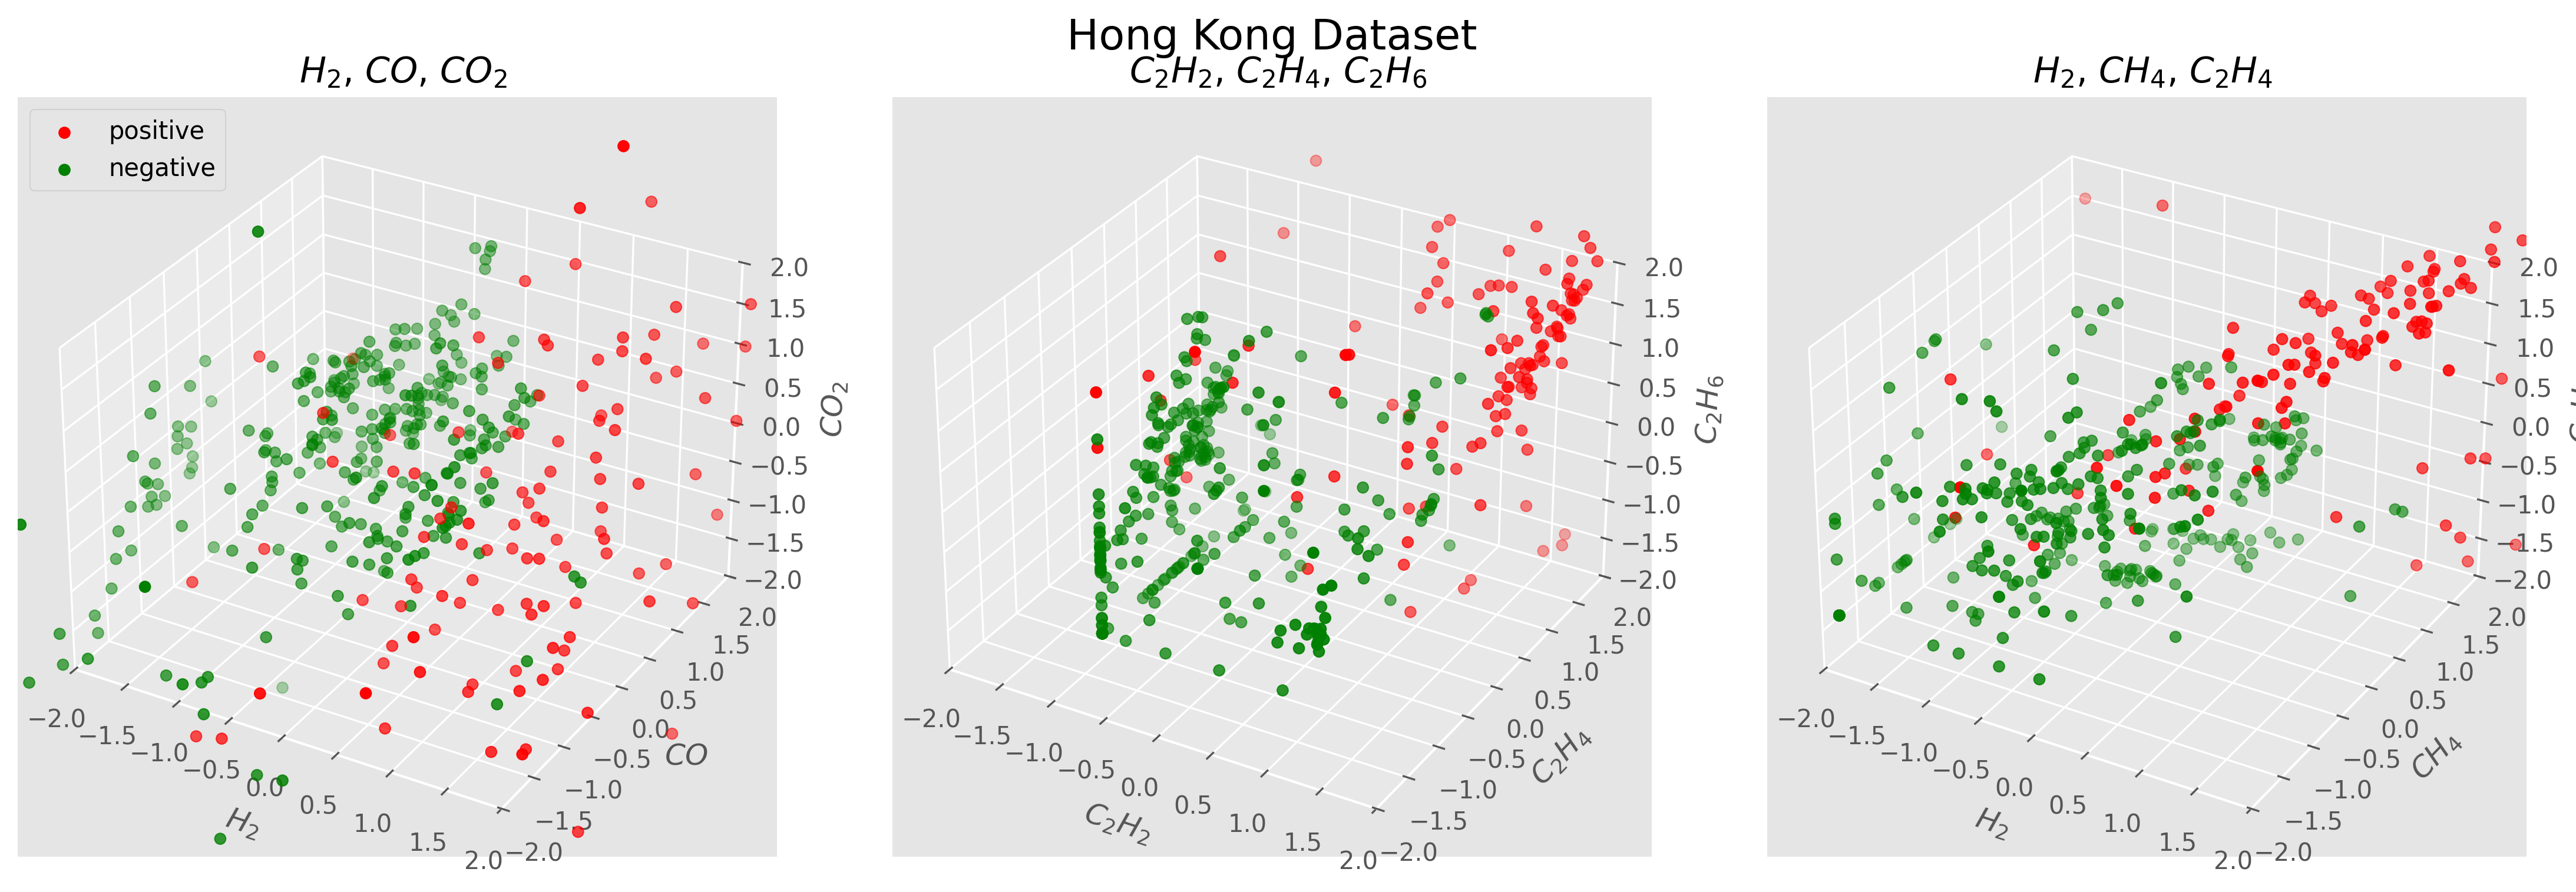

In [5]:
def plot_datasets(X, y, title=''):
    axis_labels = X.columns
    X = pd.DataFrame(pipeline.fit_transform(X))
    # Initiate the plot
    fig = plt.figure(figsize=(15,5), dpi=300)
    fig.suptitle(title, size='xx-large')
    DGA_plot3d(X[[0, 5, 6]], y, axis_labels[[0, 5, 6]], fig, (1,3,1))
    plt.legend()
    DGA_plot3d(X[[2, 3, 4]], y, axis_labels[[2, 3, 4]], fig, (1,3,2))
    DGA_plot3d(X[[0, 1, 3]], y, axis_labels[[0, 1, 3]], fig, (1,3,3), ax_title='')
    plt.tight_layout()
    plt.show()
    plt.close()

plot_datasets(tc10_data, tc10_labels, title='TC 10 Dataset')
plot_datasets(hk_data, hk_labels, title='Hong Kong Dataset')

## Compare SMOTE and reweight


In [6]:
def DGA_modelling(X, y, pipeline, SMOTE_toggle, architecture, dataset):
    # Apply SMOTE if SMOTE_toggle is 1
    if SMOTE_toggle == 1:
        X, y = smote_data, smote_labels
    
    # Perform 5-fold cross-validation
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'roc_auc': make_scorer(roc_auc_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score),
        'average_precision': make_scorer(average_precision_score)
    }
    
    cv_results = cross_validate(pipeline, X, y, cv=5, scoring=scoring)
    
    # Collect results
    results = {
        'Architecture': architecture,
        'Dataset': dataset,
        'Preprocessing': 'Y–J transformation',
        'Accuracy': np.mean(cv_results['test_accuracy']),
        'ROC AUC': np.mean(cv_results['test_roc_auc']),
        'Precision': np.mean(cv_results['test_precision']),
        'Recall': np.mean(cv_results['test_recall']),
        'PR AUC': np.mean(cv_results['test_average_precision']),
        'F1 Score': np.mean(cv_results['test_f1'])
    }
    
    return results

# Initialize results list
results_list = []

# For class_weight method
pipeline_balanced = Pipeline([
    ('yj_transform', PowerTransformer()),
    ('svc', SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=41))
])
results_list.append(DGA_modelling(tc10_data, tc10_labels, pipeline_balanced, SMOTE_toggle=0, architecture='SVC (rbf)', dataset='balanced'))

# For SMOTE method
pipeline_smote = ImbPipeline([
    ('yj_transform', PowerTransformer()),
    ('svc', SVC(kernel='rbf', probability=True, random_state=41))
])
results_list.append(DGA_modelling(tc10_data, tc10_labels, pipeline_smote, SMOTE_toggle=1, architecture='SVC (rbf)', dataset='SMOTE-balanced'))

# Display results as DataFrame
pd.DataFrame(results_list)


,Architecture,Dataset,Preprocessing,Accuracy,ROC AUC,Precision,Recall,PR AUC,F1 Score
0,SVC (rbf),balanced,Y–J transformation,0.8854,0.9066,0.9784,0.8533,0.9393,0.9100
1,SVC (rbf),SMOTE-balanced,Y–J transformation,0.9100,0.9094,0.9709,0.8446,0.8972,0.9008


### PR and ROC Curves

In [7]:
def DGA_modelling(checkpoints):
    results_list = []

    scoring = {
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'average_precision': 'average_precision'
    }

    for checkpoint in checkpoints:
        X, y = checkpoint['data'], checkpoint['labels']
        cv_results = cross_validate(checkpoint['pipeline'], X, y, cv=5, scoring=scoring)

        results_list.append({
            'Architecture': checkpoint['architecture'],
            'Dataset': checkpoint['dataset'],
            'Preprocessing': checkpoint['prepocessing'],
            'Accuracy': np.mean(cv_results['test_accuracy']),
            'ROC AUC': np.mean(cv_results['test_roc_auc']),
            'Precision': np.mean(cv_results['test_precision']),
            'Recall': np.mean(cv_results['test_recall']),
            'PR AUC': np.mean(cv_results['test_average_precision']),
            'F1 Score': np.mean(cv_results['test_f1'])
        })

    return results_list



In [8]:
def Plot_PR_ROC(checkpoints):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=150)
    
    for checkpoint in checkpoints:
        X = checkpoint['data']
        y = checkpoint['labels']
        pipeline = checkpoint['pipeline']
        legend = checkpoint['legend']
        
        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)
        
        # Fit the model
        pipeline.fit(X_train, y_train)
        
        # Predict probabilities
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        
        # Compute PR curve
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = average_precision_score(y_test, y_prob)
        
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        # Plot PR curve
        axs[0].plot(recall, precision, label=f'{legend}, AP={pr_auc:.4f}, ROC={roc_auc:.4f}')
        
        # Plot ROC curve
        axs[1].plot(fpr, tpr)
    
    # PR Curve settings
    axs[0].set_title('PR Curve')
    axs[0].set_xlabel('Recall')
    axs[0].set_ylabel('Precision')
    axs[0].legend(loc='best')
    axs[0].set_xlim(0.5, 1)
    axs[0].set_ylim(0.5, 1)
    axs[0].autoscale()
    
    # ROC Curve settings
    axs[1].set_title('ROC Curve')
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive Rate')
    
    plt.tight_layout()
    plt.show()


c:\Users\chanttsh\AppData\Local\miniconda3\envs\env1\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\chanttsh\AppData\Local\miniconda3\envs\env1\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\chanttsh\AppData\Local\miniconda3\envs\env1\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator.

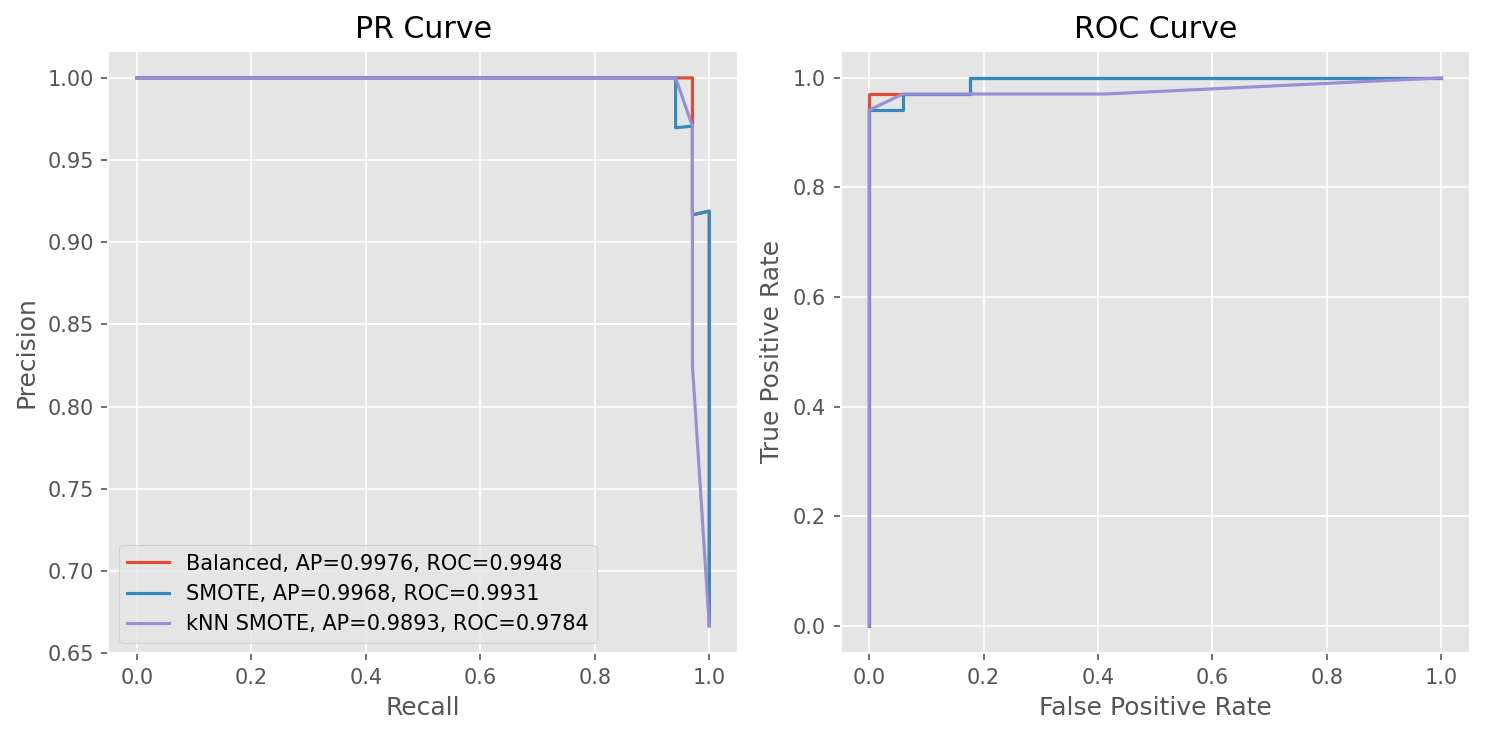

In [9]:
pipeline_balanced = Pipeline([
    ('yj_transform', PowerTransformer()),
    ('std_scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', class_weight='balanced', probability=True))
])

pipeline_smote = ImbPipeline([
    ('yj_transform', PowerTransformer()),
    ('std_scaler', StandardScaler()),
    ('smote', SMOTE()),
    ('svc', SVC(kernel='rbf', probability=True))
])

pipeline_knn_smote = ImbPipeline([
    ('yj_transform', PowerTransformer()),
    ('std_scaler', StandardScaler()),
    ('smote', SMOTE()),
    ('knn', KNeighborsClassifier())
])

# Define checkpoints
checkpoints = [
    {
        'data': tc10_data,
        'labels': tc10_labels,
        'architecture': 'SVC (rbf)',
        'dataset': 'TC 10, balanced',
        'prepocessing': 'Y–J, z-transform',
        'pipeline': pipeline_balanced,
        'legend': 'Balanced'
    },
    {
        'data': tc10_data,
        'labels': tc10_labels,
        'architecture': 'SVC (rbf)',
        'dataset': 'SMOTE',
        'prepocessing': 'Y–J, z-transform',
        'pipeline': pipeline_smote,
        'legend': 'SMOTE'
    },
    {
        'data': tc10_data,
        'labels': tc10_labels,
        'architecture': 'kNN',
        'dataset': 'SMOTE',
        'prepocessing': 'Y–J, z-transform',
        'pipeline': pipeline_knn_smote,
        'legend': 'kNN SMOTE'
    },
]

# Run the functions
results_list = DGA_modelling(checkpoints)
pd.DataFrame(results_list)

Plot_PR_ROC(checkpoints)


## Compare datasets

,Architecture,Dataset,Preprocessing,Accuracy,ROC AUC,Precision,Recall,PR AUC,F1 Score
0,SVC (rbf),TC 10,Y–J transformation,0.8854,0.9330,0.9373,0.8967,0.9677,0.9157
1,SVC (rbf),Mirowski,Y–J transformation,0.8584,0.9532,0.8861,0.8620,0.9644,0.8637
2,SVC (rbf),SMOTE,Y–J transformation,0.9100,0.9801,0.9709,0.8446,0.9842,0.9008
3,SVC (rbf),Hong Kong,Y–J transformation,0.9317,0.9607,0.9260,0.8460,0.9445,0.8785


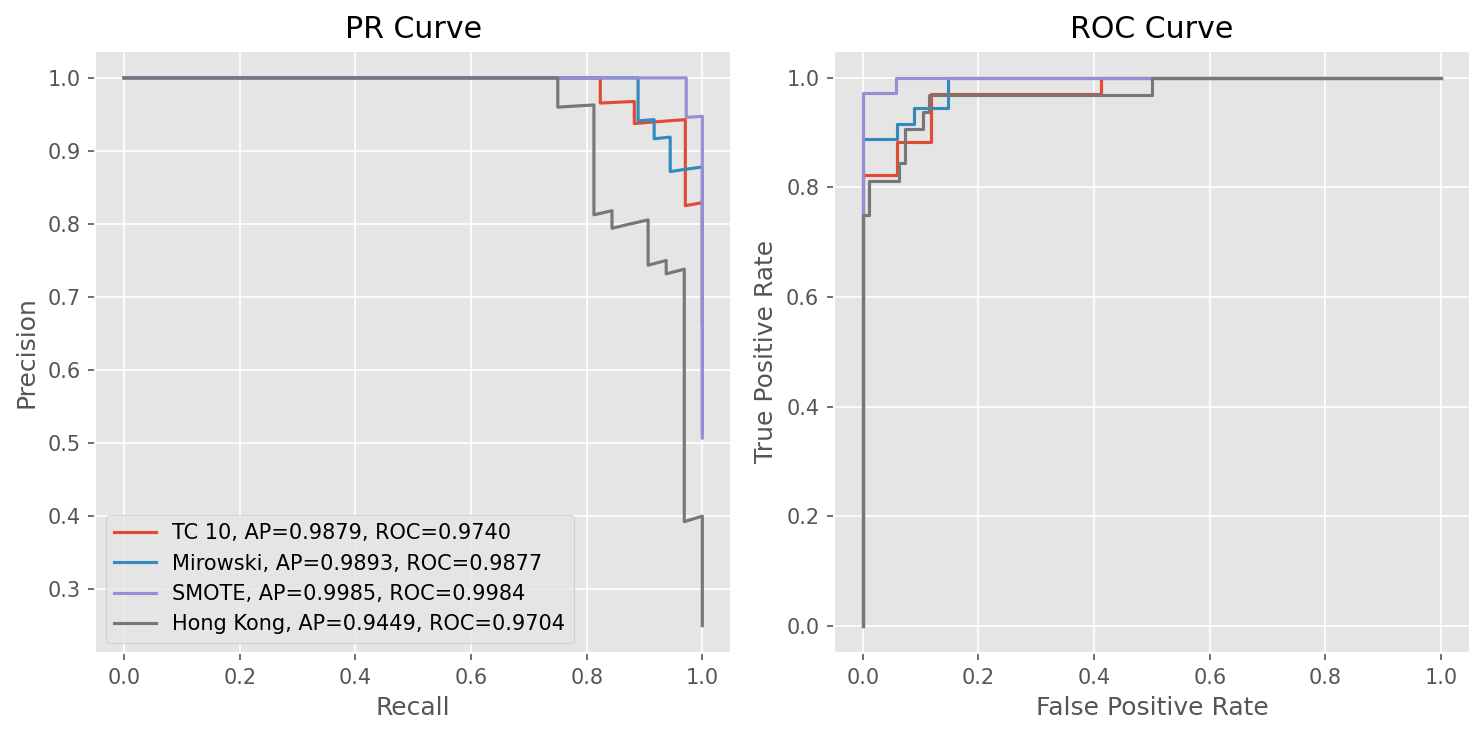

In [10]:
pipeline_svc_rbf = Pipeline([
    ('yj_transform', PowerTransformer()),
    ('svc', SVC(kernel='rbf', probability=True, random_state=41))
])

checkpoints = [
    {
        'data': tc10_data,
        'labels': tc10_labels,
        'architecture': 'SVC (rbf)',
        'dataset': 'TC 10',
        'prepocessing': 'Y–J transformation',
        'pipeline': pipeline_svc_rbf,
        'legend': 'TC 10'
    },
    {
        'data': mirowski_data,
        'labels': mirowski_labels,
        'architecture': 'SVC (rbf)',
        'dataset': 'Mirowski',
        'prepocessing': 'Y–J transformation',
        'pipeline': pipeline_svc_rbf,
        'legend': 'Mirowski'
    },
    {
        'data': smote_data,
        'labels': smote_labels,
        'architecture': 'SVC (rbf)',
        'dataset': 'SMOTE',
        'prepocessing': 'Y–J transformation',
        'pipeline': pipeline_svc_rbf,
        'legend': 'SMOTE'
    },
    {
        'data': hk_data,
        'labels': hk_labels,
        'architecture': 'SVC (rbf)',
        'dataset': 'Hong Kong',
        'prepocessing': 'Y–J transformation',
        'pipeline': pipeline_svc_rbf,
        'legend': 'Hong Kong'
    }
]

results_list = DGA_modelling(checkpoints)
display(pd.DataFrame(results_list))
Plot_PR_ROC(checkpoints)

## Compare different models

see effect on tc 10 data set

,Architecture,Dataset,Preprocessing,Accuracy,ROC AUC,Precision,Recall,PR AUC,F1 Score
0,kNN,TC 10,Y–J transformation,0.8670,0.9031,0.9391,0.8616,0.9501,0.8968
1,Random Forest,TC 10,Y–J transformation,0.9032,0.9413,0.9317,0.9308,0.9725,0.9308
2,SVC (linear),TC 10,Y–J transformation,0.7426,0.8039,0.8616,0.7525,0.9170,0.7972
3,SVC (poly),TC 10,Y–J transformation,0.7902,0.8892,0.7828,0.9739,0.9506,0.8669
4,SVC (rbf),TC 10,Y–J transformation,0.8854,0.9330,0.9373,0.8967,0.9677,0.9157
5,NN,TC 10,Y–J transformation,0.8913,0.9261,0.9298,0.9134,0.9686,0.9202


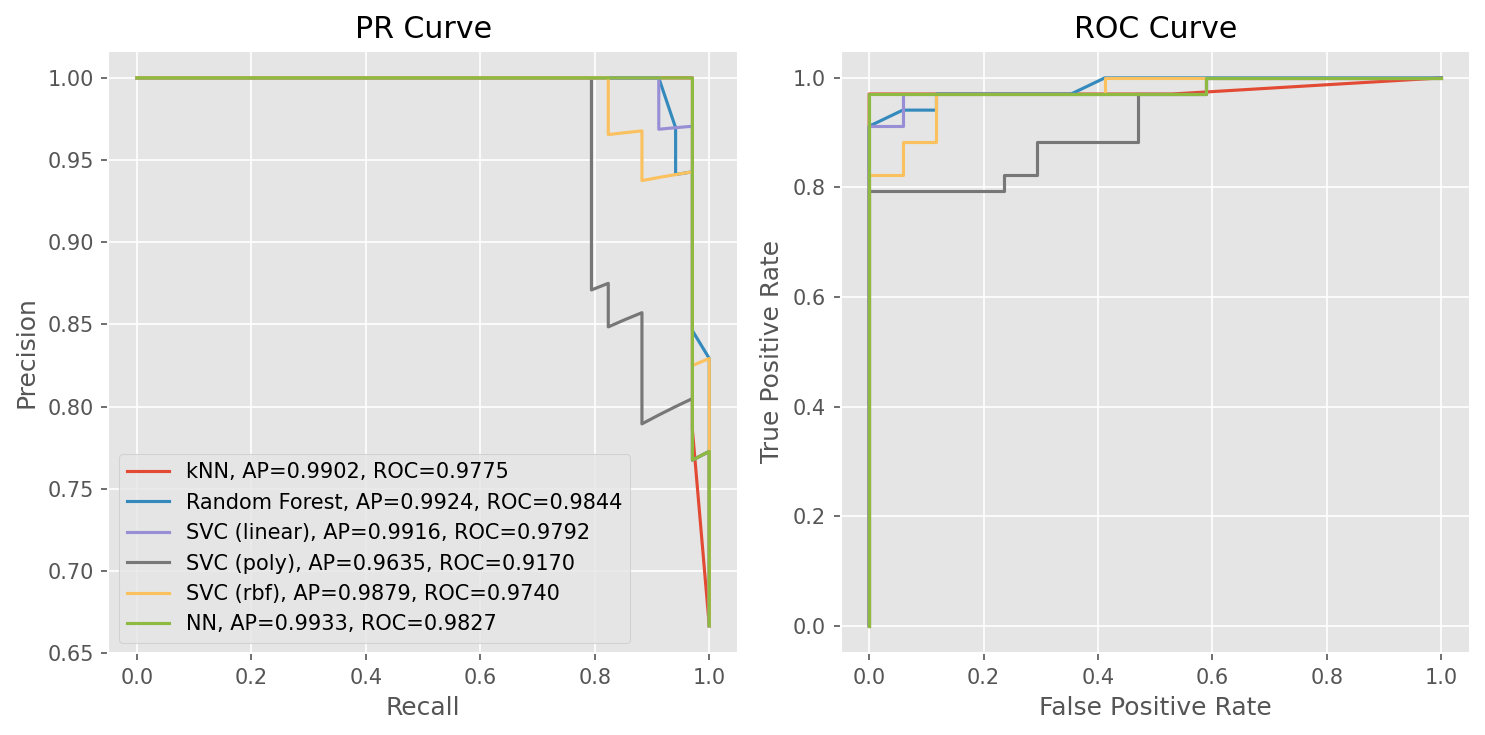

In [11]:
# Define checkpoints for different models
checkpoints = [
    {
        'data': tc10_data,
        'labels': tc10_labels,
        'architecture': 'kNN',
        'dataset': 'TC 10',
        'prepocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('knn', KNeighborsClassifier())
        ]),
        'legend': 'kNN'
    },
    {
        'data': tc10_data,
        'labels': tc10_labels,
        'architecture': 'Random Forest',
        'dataset': 'TC 10',
        'prepocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('rf', RandomForestClassifier())
        ]),
        'legend': 'Random Forest'
    },
    {
        'data': tc10_data,
        'labels': tc10_labels,
        'architecture': 'SVC (linear)',
        'dataset': 'TC 10',
        'prepocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('svc', SVC(kernel='linear', probability=True, random_state=41))
        ]),
        'legend': 'SVC (linear)'
    },
    {
        'data': tc10_data,
        'labels': tc10_labels,
        'architecture': 'SVC (poly)',
        'dataset': 'TC 10',
        'prepocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('svc', SVC(kernel='poly', probability=True, random_state=41))
        ]),
        'legend': 'SVC (poly)'
    },
    {
        'data': tc10_data,
        'labels': tc10_labels,
        'architecture': 'SVC (rbf)',
        'dataset': 'TC 10',
        'prepocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('svc', SVC(kernel='rbf', probability=True, random_state=41))
        ]),
        'legend': 'SVC (rbf)'
    },
    {
        'data': tc10_data,
        'labels': tc10_labels,
        'architecture': 'NN',
        'dataset': 'TC 10',
        'prepocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('nn', MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='sgd', max_iter=10000, random_state=41))
        ]),
        'legend': 'NN'
    }
]


results_list = DGA_modelling(checkpoints)
display(pd.DataFrame(results_list))
Plot_PR_ROC(checkpoints)

see effect on hk data set

,Architecture,Dataset,Preprocessing,Accuracy,ROC AUC,Precision,Recall,PR AUC,F1 Score
0,kNN,hk,Y–J transformation,0.9410,0.9450,0.9600,0.8290,0.9092,0.8877
1,Random Forest,hk,Y–J transformation,0.9364,0.9715,0.9284,0.8627,0.9486,0.8877
2,SVC (linear),hk,Y–J transformation,0.9152,0.9383,0.8850,0.8370,0.9153,0.8522
3,SVC (poly),hk,Y–J transformation,0.9316,0.9294,0.9895,0.7601,0.9247,0.8593
4,SVC (rbf),hk,Y–J transformation,0.9317,0.9607,0.9260,0.8460,0.9445,0.8785
5,NN,hk,Y–J transformation,0.9081,0.9484,0.8623,0.8457,0.9256,0.8461


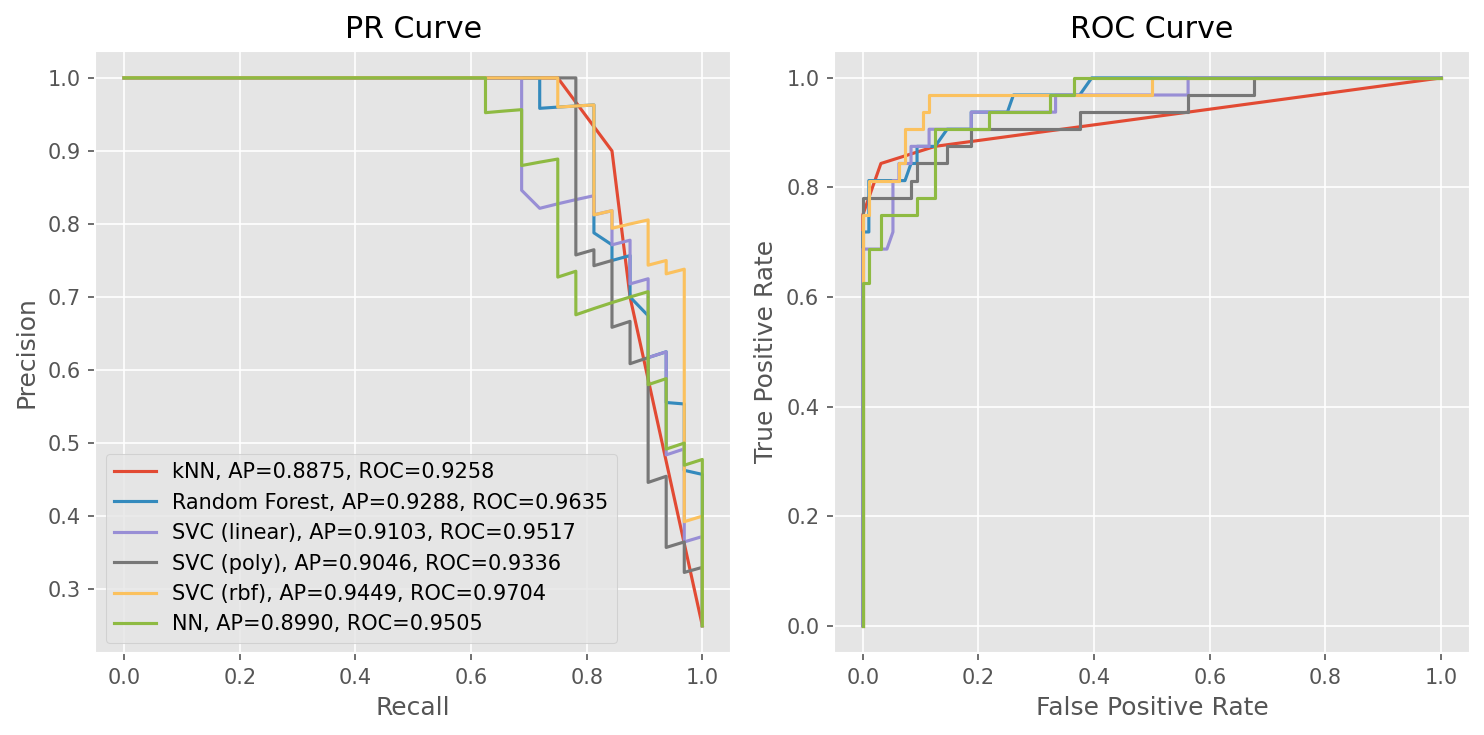

In [12]:
# Define checkpoints for different models
checkpoints = [
    {
        'data': hk_data,
        'labels': hk_labels,
        'architecture': 'kNN',
        'dataset': 'hk',
        'prepocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('knn', KNeighborsClassifier())
        ]),
        'legend': 'kNN'
    },
    {
        'data': hk_data,
        'labels': hk_labels,
        'architecture': 'Random Forest',
        'dataset': 'hk',
        'prepocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('rf', RandomForestClassifier())
        ]),
        'legend': 'Random Forest'
    },
    {
        'data': hk_data,
        'labels': hk_labels,
        'architecture': 'SVC (linear)',
        'dataset': 'hk',
        'prepocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('svc', SVC(kernel='linear', probability=True, random_state=41))
        ]),
        'legend': 'SVC (linear)'
    },
    {
        'data': hk_data,
        'labels': hk_labels,
        'architecture': 'SVC (poly)',
        'dataset': 'hk',
        'prepocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('svc', SVC(kernel='poly', probability=True, random_state=41))
        ]),
        'legend': 'SVC (poly)'
    },
    {
        'data': hk_data,
        'labels': hk_labels,
        'architecture': 'SVC (rbf)',
        'dataset': 'hk',
        'prepocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('svc', SVC(kernel='rbf', probability=True, random_state=41))
        ]),
        'legend': 'SVC (rbf)'
    },
    {
        'data': hk_data,
        'labels': hk_labels,
        'architecture': 'NN',
        'dataset': 'hk',
        'prepocessing': 'Y–J transformation',
        'pipeline': Pipeline([
            ('yj_transform', PowerTransformer()),
            ('nn', MLPClassifier(hidden_layer_sizes=(10,), activation='relu', solver='sgd', max_iter=10000, random_state=41))
        ]),
        'legend': 'NN'
    }
]


results_list = DGA_modelling(checkpoints)
display(pd.DataFrame(results_list))
Plot_PR_ROC(checkpoints)

## Train and test for TC10 data using SVC and RF

In [13]:
# Train-Test Split with Stratification
X_train, X_test, y_train, y_test = train_test_split(tc10_data, tc10_labels, test_size=0.3, random_state=41, stratify=tc10_labels)

# Preprocessing with Yeo-Johnson Transformation
power_transformer = PowerTransformer()

# Define models and their corresponding parameter grids
models = {
    'SVC': {
        'pipeline': Pipeline([
            ('yj_transform', power_transformer),
            ('svc', SVC(kernel='rbf', probability=True, random_state=41))
        ]),
        'param_grid': {
            'svc__C': np.logspace(-3, 3, num=7),  # C values from 0.001 to 1000
            'svc__gamma': ['scale', 'auto']
        }
    },
    'Random Forest': {
        'pipeline': Pipeline([
            ('yj_transform', power_transformer),
            ('rf', RandomForestClassifier(random_state=41))
        ]),
        'param_grid': {
            'rf__n_estimators': [50, 100, 200],
            'rf__max_depth': [None, 10, 20]
        }
    }
}

# Stratified K-Folds for better representation of classes
stratified_kfold = StratifiedKFold(n_splits=5)

# Initialize results list
results_list = []

# Loop through each model to perform hyperparameter tuning and evaluation
for architecture, model_info in models.items():
    # Halving Grid search for the current model
    halving_grid = HalvingGridSearchCV(
        model_info['pipeline'], model_info['param_grid'],
        cv=stratified_kfold, scoring='roc_auc',
        factor=2, min_resources='exhaust', n_jobs=-1
    )
    
    # Fit the model
    halving_grid.fit(X_train, y_train)
    
    # Predictions on the test set
    y_pred = halving_grid.predict(X_test)
    y_prob = halving_grid.predict_proba(X_test)[:, 1]
    
    # Calculate metrics for the current model
    metrics = {
        'Architecture': architecture,
        'Dataset': 'TC10',
        'Accuracy': accuracy_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'Average Precision': average_precision_score(y_test, y_prob)
    }
    
    results_list.append(metrics)
    
    # Print best parameters for the current model
    print(f"Best parameters for {architecture}:", halving_grid.best_params_)

# Display results as a DataFrame
display(pd.DataFrame(results_list))


Best parameters for SVC: {'svc__C': np.float64(10.0), 'svc__gamma': 'scale'}


c:\Users\chanttsh\AppData\Local\miniconda3\envs\env1\Lib\site-packages\sklearn\model_selection\_search.py:1107: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\chanttsh\AppData\Local\miniconda3\envs\env1\Lib\site-packages\sklearn\model_selection\_search.py:1107: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.93333333 0.93333333 0.87
 0.93333333 0.93333333]
  warnings.warn(
c:\Users\chanttsh\AppData\Local\miniconda3\envs\env1\Lib\site-packages\sklearn\model_selection\_search.py:1107: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.93333333 0.93333333 0.87
 0.93333333 0.93333333 0.95690909 0.95145455 0.95690909]
  warnings.warn(


Best parameters for Random Forest: {'rf__max_depth': 10, 'rf__n_estimators': 200}


,Architecture,Dataset,Accuracy,ROC AUC,Precision,Recall,F1 Score,Average Precision
0,SVC,TC10,0.8431,0.9407,0.9667,0.8056,0.8788,0.9763
1,Random Forest,TC10,0.9020,0.9148,0.9429,0.9167,0.9296,0.9437
